In [10]:
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from mimic3benchmark.readers import ReadmissionReader
from mimic3benchmark.util import *
from mimic3models import common_utils
from mimic3models.metrics import print_metrics_binary
from mimic3models.preprocessing import Discretizer
from mimic3models.readmission_baselines.logistic_cv_0.OF_util import *
from mimic3models.readmission_baselines.utils import save_results
from utilities.data_loader import get_embeddings

In [2]:
fig = plt.figure(figsize=(7, 7))

base = "../../../scripts/"
subject_data = "output_subjects_1000"
episodes_data = "output_episodes_1000"
listfiles_data = "output_listfiles_1000"
dataset_subject_dir = base + subject_data + "/"
dataset_episode_dir = base + episodes_data + "/"
listfiles_train_dir0 = base + listfiles_data + "/0_train_listfile801010.csv"
listfiles_val_dir0 = base + listfiles_data + "/0_val_listfile801010.csv"
listfiles_test_dir0 = base + listfiles_data + "/0_test_listfile801010.csv"

embeddings, word_indices = get_embeddings(corpus='claims_codes_hs', dim=300)

# Build readers, discretizers, normalizers
train_reader = ReadmissionReader(dataset_dir=dataset_episode_dir,
                                 listfile=listfiles_train_dir0)

val_reader = ReadmissionReader(dataset_dir=dataset_episode_dir,
                               listfile=listfiles_val_dir0)

test_reader = ReadmissionReader(dataset_dir=dataset_episode_dir,
                                listfile=listfiles_test_dir0)

discretizer = Discretizer(timestep=float(1.0),
                          store_masks=True,
                          imput_strategy='previous',
                          start_time='zero')

N = train_reader.get_number_of_examples()
ret = common_utils.read_chunk(train_reader, N)
data = ret["X"]
ts = ret["t"]
train_y = ret["y"]
train_names = ret["name"]

Loaded 51328 word vectors.
loading i: 1
loading i: 26
loading i: 51
loading i: 76


<Figure size 504x504 with 0 Axes>

In [19]:
diseases_list = get_diseases(train_names, dataset_subject_dir)
print (diseases_list)
diseases_embedding = disease_embedding(embeddings, word_indices, diseases_list)

([[7907, 7907, 5856, 5856, 42731, 42731, 45341, 45341, 73313, 73313, 56985, 56985, 2875, 2875, 99812, 99812, 2851, 2851, 56949, 56949, 2449, 2449, 73300, 73300, 5738, 5738, 2930, 2930], ['20280', '20280', '5849', '5849', '51881', '51881', '9986', '9986', '28489', '28489', '78959', '78959', '2762', '2762', '2760', '2760', 'V4282', 'V4282', '27652', '27652', '2875', '2875', '78061', '78061', '25000', '25000', 'V1052', 'V1052', 'V4573', 'V4573', '5768', '5768', '78791', '78791', '6023', '6023', '6869', '6869', 'E8786', 'E8786', '28803', '28803', 'E9331', 'E9331'], ['56212', '78559', '2851', '41401', '4019', '2724', '2449', 'V4582'], ['41401', '4139', '9971', '7140', '25070', '44020', 'E8790', 'E8497', '41412'], [41091, 4280, 78551, 4275, 42731, 99811, 2869, 4254, 4239], [41401, 4111, 42731, 4019, 25000, 2720, 41072], ['0389', '41519', '4280', '496', '51884', '4254', '78552', '78551', '5849', '3051', '4019', '30392', '42731', '4168', 'V4501', '4240', '99592'], ['8024', '8028', '8020', '873

TypeError: 'NoneType' object is not iterable

In [ ]:
feature_cols = ['LOS', 'Hos_LOS', 'Num_Prev_Hos_Adm']
additional_features = get_additional_features(base, train_names)
# additional_features_list = normalize_standard(additional_features, feature_cols).values.tolist()

d, discretizer_header, begin_pos, end_pos = discretizer.transform_reg(data[0])

discretizer_header = discretizer_header.split(',')

cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

da = [discretizer.transform_end_t_hours_reg(X, los=t)[1] for (X, t) in zip(data, ts)]
mask = [column_sum(x) for x in da]

# train_set=[]
d = [discretizer.transform_end_t_hours_reg(X, los=t)[0] for (X, t) in zip(data, ts)]

idx_features_train = [logit(X, cont_channels, begin_pos, end_pos)[0] for X in d]
features_train = [logit(X, cont_channels, begin_pos, end_pos)[1] for X in d]
features_train_extended = [np.hstack([X, d]) for (X, d) in zip(features_train, additional_features.values.tolist())]

In [ ]:
train_X = features_train_extended

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

train_X = [np.hstack([X, d]) for (X, d) in zip(train_X, diseases_embedding)]

train_X = [np.hstack([X, d]) for (X, d) in zip(train_X, idx_features_train)]

train_X = [np.hstack([X, d]) for (X, d) in zip(train_X, mask)]

In [ ]:
labels_1 = []
labels_0 = []
data_1 = []
data_0 = []
for i in range(len(train_y)):
    if train_y[i] == 1:
        labels_1.append(train_y[i])
        data_1.append(train_X[i])
    elif train_y[i] == 0:
        labels_0.append(train_y[i])
        data_0.append(train_X[i])

print('labels_1:', len(labels_1))
print('labels_0:', len(labels_0))
indices = np.random.choice(len(labels_0), len(labels_1), replace=False)
labels_0_sample = [labels_0[idx] for idx in indices]
# print('labels_0_sample: ', labels_0_sample)
print('len(labels_0_sample): ', len(labels_0_sample))

data_0_sample = [data_0[idx] for idx in indices]
# print('data_0_sample: ', data_0_sample)
print('len(data_0_sample): ', len(data_0_sample))

data_new = data_0_sample + data_1
label_new = labels_0_sample + labels_1

c = list(zip(data_new, label_new))

random.shuffle(c)

data_new, label_new = zip(*c)
train_X = list(data_new)
train_y = list(label_new)
# print('data_new: ', data_new)
print('data_new: ', len(train_X))
# print('label_new: ', label_new)
print('label_new: ', len(train_y))

# -------------------------

N_val = val_reader.get_number_of_examples()
ret_val = common_utils.read_chunk(val_reader, N_val)
data_val = ret_val["X"]
ts_val = ret_val["t"]
val_y = ret_val["y"]
val_names = ret_val["name"]

diseases_list_val, data_feature_names_val = get_diseases(val_names, dataset_subject_dir)
diseases_embedding_val = disease_embedding(embeddings, word_indices, diseases_list_val)
additional_features = get_additional_features(base, val_names)

# ----------
da_val = [discretizer.transform_end_t_hours_reg(X, los=t)[1] for (X, t) in zip(data_val, ts_val)]
mask_val = [column_sum(x) for x in da_val]

# train_set=[]
d_val = [discretizer.transform_end_t_hours_reg(X, los=t)[0] for (X, t) in zip(data_val, ts_val)]

# ---------
# val_set=[]
idx_features_val = [logit(X, cont_channels, begin_pos, end_pos)[0] for X in d_val]
features_val = [logit(X, cont_channels, begin_pos, end_pos)[1] for X in d_val]
features_val_extended = [np.hstack([X, d]) for (X, d) in zip(features_train, additional_features.values.tolist())]

val_X = scaler.transform(features_val_extended)

val_X = [np.hstack([X, d]) for (X, d) in zip(val_X, diseases_embedding_val)]
val_X = [np.hstack([X, d]) for (X, d) in zip(val_X, idx_features_val)]
val_X = [np.hstack([X, d]) for (X, d) in zip(val_X, mask_val)]

# -------------------------

N_test = test_reader.get_number_of_examples()
ret_test = common_utils.read_chunk(test_reader, N_test)
data_test = ret_test["X"]
ts_test = ret_test["t"]
test_y = ret_test["y"]
test_names = ret_test["name"]

diseases_list_test, data_feature_names_test = get_diseases(test_names, dataset_subject_dir)
diseases_embedding_test = disease_embedding(embeddings, word_indices, diseases_list_test)
additional_features = get_additional_features(base, test_names)

# ----------
da_test = [discretizer.transform_end_t_hours_reg(X, los=t)[1] for (X, t) in zip(data_test, ts_test)]
mask_test = [column_sum(x) for x in da_test]

# train_set=[]
d_test = [discretizer.transform_end_t_hours_reg(X, los=t)[0] for (X, t) in zip(data_test, ts_test)]
# ----------

# data_test=[]
idx_features_test = [logit(X, cont_channels, begin_pos, end_pos)[0] for X in d_test]
features_test = [logit(X, cont_channels, begin_pos, end_pos)[1] for X in d_test]
features_test_extended = [np.hstack([X, d]) for (X, d) in zip(features_train, additional_features.values.tolist())]

test_X = scaler.transform(features_test_extended)

test_X = [np.hstack([X, d]) for (X, d) in zip(test_X, diseases_embedding_test)]
test_X = [np.hstack([X, d]) for (X, d) in zip(test_X, idx_features_test)]
test_X = [np.hstack([X, d]) for (X, d) in zip(test_X, mask_test)]

confusion matrix:
[[970 281]
 [304 947]]
accuracy = 0.7661871
precision class 0 = 0.76138145
precision class 1 = 0.77117264
recall class 0 = 0.7753797
recall calss 1 = 0.7569944
AUC of ROC = 0.8569879508064211
AUC of PRC = 0.8434151914153506
F1 Score = 0.7640177490923759
confusion matrix:
[[133  35]
 [ 42 114]]
accuracy = 0.7623457
precision class 0 = 0.76
precision class 1 = 0.76510066
recall class 0 = 0.7916667
recall calss 1 = 0.7307692
AUC of ROC = 0.8456578144078144
AUC of PRC = 0.8245042609591317
F1 Score = 0.7475409836065573
confusion matrix:
[[120  41]
 [ 47 121]]
accuracy = 0.7325228
precision class 0 = 0.7185629
precision class 1 = 0.74691355
recall class 0 = 0.7453416
recall calss 1 = 0.7202381
AUC of ROC = 0.8110766045548654
AUC of PRC = 0.8117151206791362
F1 Score = 0.7333333333333334


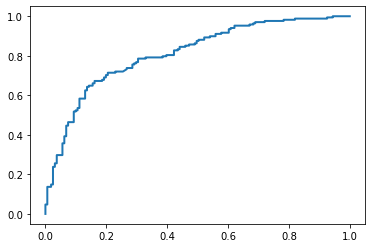

In [4]:
# =========SVM====================
penalty = ('l2')
# file_name = '{}.{}.{}.C{}'.format(penalty, 0.001)


logreg = SVC(probability=True)
logreg.fit(train_X, train_y)

# -----------------
common_utils.create_directory('svm_results')
common_utils.create_directory('svm_predictions')

with open(os.path.join('svm_results', 'train.json'), 'w') as res_file:
    ret = print_metrics_binary(train_y, logreg.predict_proba(train_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

with open(os.path.join('svm_results', 'val.json'), 'w') as res_file:
    ret = print_metrics_binary(val_y, logreg.predict_proba(val_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

prediction = logreg.predict_proba(test_X)[:, 1]

with open(os.path.join('svm_results', 'test.json'), 'w') as res_file:
    ret = print_metrics_binary(test_y, prediction)
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

    predictions = np.array(prediction)
    if (len(predictions.shape) == 1):
        predictions = np.stack([1 - predictions, predictions]).transpose((1, 0))

    fpr, tpr, thresh = metrics.roc_curve(test_y, predictions[:, 1])
    auc = metrics.roc_auc_score(test_y, predictions[:, 1])
    plt.plot(fpr, tpr, lw=2, label="SVM= %0.3f" % auc)

save_results(test_names, prediction, test_y, os.path.join('svm_predictions', 'svm.csv'))

In [ ]:
svm_f_importance(logreg.coef, )

In [ ]:
# =============LR================


logreg = LogisticRegression(penalty=penalty, C=0.001, random_state=42)
logreg.fit(train_X, train_y)

# -----------------
common_utils.create_directory('lr_results')
common_utils.create_directory('lr_predictions')

with open(os.path.join('lr_results', 'train.json'), 'w') as res_file:
    ret = print_metrics_binary(train_y, logreg.predict_proba(train_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

with open(os.path.join('lr_results', 'val.json'), 'w') as res_file:
    ret = print_metrics_binary(val_y, logreg.predict_proba(val_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

prediction = logreg.predict_proba(test_X)[:, 1]

with open(os.path.join('lr_results', 'test.json'), 'w') as res_file:
    ret = print_metrics_binary(test_y, prediction)
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

    predictions = np.array(prediction)
    if (len(predictions.shape) == 1):
        predictions = np.stack([1 - predictions, predictions]).transpose((1, 0))

    fpr, tpr, thresh = metrics.roc_curve(test_y, predictions[:, 1])
    auc = metrics.roc_auc_score(test_y, predictions[:, 1])
    plt.plot(fpr, tpr, lw=2, label="LR= %0.3f" % auc)

save_results(test_names, prediction, test_y, os.path.join('lr_predictions', 'lr.csv'))

# ===========RF==================


logreg = RandomForestClassifier(oob_score=True, max_depth=50, random_state=0)
logreg.fit(train_X, train_y)

# -----------------
common_utils.create_directory('rf_results')
common_utils.create_directory('rf_predictions')

with open(os.path.join('rf_results', 'train.json'), 'w') as res_file:
    ret = print_metrics_binary(train_y, logreg.predict_proba(train_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

with open(os.path.join('rf_results', 'val.json'), 'w') as res_file:
    ret = print_metrics_binary(val_y, logreg.predict_proba(val_X))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

prediction = logreg.predict_proba(test_X)[:, 1]

with open(os.path.join('rf_results', 'test.json'), 'w') as res_file:
    ret = print_metrics_binary(test_y, prediction)
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

    predictions = np.array(prediction)
    if (len(predictions.shape) == 1):
        predictions = np.stack([1 - predictions, predictions]).transpose((1, 0))

    fpr, tpr, thresh = metrics.roc_curve(test_y, predictions[:, 1])
    auc = metrics.roc_auc_score(test_y, predictions[:, 1])
    plt.plot(fpr, tpr, lw=2, label="RF= %0.3f" % auc)

save_results(test_names, prediction, test_y, os.path.join('rf_predictions', 'rf.csv'))

# =============NB================


# logreg = GaussianNB()
# logreg.fit(train_X, train_y)
#
# # -----------------
# common_utils.create_directory('nb_results')
# common_utils.create_directory('nb_predictions')
#
# with open(os.path.join('nb_results', 'train.json'), 'w') as res_file:
#     ret = print_metrics_binary(train_y, logreg.predict_proba(train_X))
#     ret = {k: float(v) for k, v in ret.items()}
#     json.dump(ret, res_file)
#
# with open(os.path.join('nb_results', 'val.json'), 'w') as res_file:
#     ret = print_metrics_binary(val_y, logreg.predict_proba(val_X))
#     ret = {k: float(v) for k, v in ret.items()}
#     json.dump(ret, res_file)
#
# prediction = logreg.predict_proba(test_X)[:, 1]
#
# with open(os.path.join('nb_results', 'test.json'), 'w') as res_file:
#     ret = print_metrics_binary(test_y, prediction)
#     ret = {k: float(v) for k, v in ret.items()}
#     json.dump(ret, res_file)
#
#     predictions = np.array(prediction)
#     if (len(predictions.shape) == 1):
#         predictions = np.stack([1 - predictions, predictions]).transpose((1, 0))
#
#     fpr, tpr, thresh = metrics.roc_curve(test_y, predictions[:, 1])
#     auc = metrics.roc_auc_score(test_y, predictions[:, 1])
#     plt.plot(fpr, tpr, lw=2, label="NB= %0.3f" % auc)
#
# save_results(test_names, prediction, test_y, os.path.join('nb_predictions', 'nb.csv'))

# =============================
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')

plt.xlim([0., 1.])
plt.ylim([0., 1.])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

fig.savefig('ROC0.png')

plt.show()

